In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import shap
import graphviz

In [380]:
# Step 1: Data Preparation
url = "https://archive.ics.uci.edu/dataset/222/bank+marketing"
file_path = "/kaggle/input/bankmarketing/bank/bank-full.csv"
df = pd.read_csv(file_path, sep=";")

In [381]:
# Step 2: Exploratory Data Analysis (EDA)
df.head() # Check the first few rows

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [382]:
df.info()  # Summary of data types and missing values
df.describe()  # Basic statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [383]:
# Step 3: Feature Selection and Engineering
# Identify relevant features (e.g., age, income, education) and encode categorical variables
# Create a new DataFrame with selected columns
demographics_df = df[['age', 'job', 'marital', 'education', 'y']]

# Assuming 'y' contains 'yes' and 'no'
demographics_df['y'] = demographics_df['y'].map({'yes': 1, 'no': 0})

# One-hot encoding for 'job', 'marital', and 'education'
df_job_encoded = pd.get_dummies(demographics_df[['job']], drop_first=True)

df_marital_encoded = pd.get_dummies(demographics_df[['marital']], drop_first=True)

df_education_encoded = pd.get_dummies(demographics_df[['education']], drop_first=True)

# Display the first few rows of the new DataFrame
demographics_df.head()




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age,job,marital,education,y
0,58,management,married,tertiary,0
1,44,technician,single,secondary,0
2,33,entrepreneur,married,secondary,0
3,47,blue-collar,married,unknown,0
4,33,unknown,single,unknown,0


In [384]:
# Drop original categorical columns
demographics_df = demographics_df.drop(['job', 'marital', 'education'], axis=1)

In [385]:
# Concatenate the one-hot encoded DataFrames with demographics_df
X_encoded = pd.concat([demographics_df, df_job_encoded, df_marital_encoded, df_education_encoded], axis=1)

In [386]:
# Display the first few rows of the new DataFrame
X_encoded.head()

,age,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,58,0,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False
1,44,0,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False
2,33,0,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False
3,47,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
4,33,0,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True


In [387]:
# Step 4: Split the Data
# Split the encoded data
y_encoded = X_encoded['y']  # Target variable
X_encoded = X_encoded.drop('y', axis=1)  # Features

In [388]:
# Split the encoded data
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [389]:
# Check data types of features in X_train_encoded
print(X_train_encoded.dtypes)

age                    int64
job_blue-collar         bool
job_entrepreneur        bool
job_housemaid           bool
job_management          bool
job_retired             bool
job_self-employed       bool
job_services            bool
job_student             bool
job_technician          bool
job_unemployed          bool
job_unknown             bool
marital_married         bool
marital_single          bool
education_secondary     bool
education_tertiary      bool
education_unknown       bool
dtype: object


In [390]:
# Step 5: Build the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)  # Initialize the model
clf.fit(X_train_encoded, y_train_encoded)

DecisionTreeClassifier(max_depth=3)

In [391]:
# Step 6: Evaluate the Model
y_pred = clf.predict(X_test_encoded)
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("Precision:", precision_score(y_test_encoded, y_pred))
print("Recall:", recall_score(y_test_encoded, y_pred))
print("F1-score:", f1_score(y_test_encoded, y_pred))

Accuracy: 0.8794647793873714
Precision: 0.5714285714285714
Recall: 0.0036663611365719525
F1-score: 0.007285974499089254


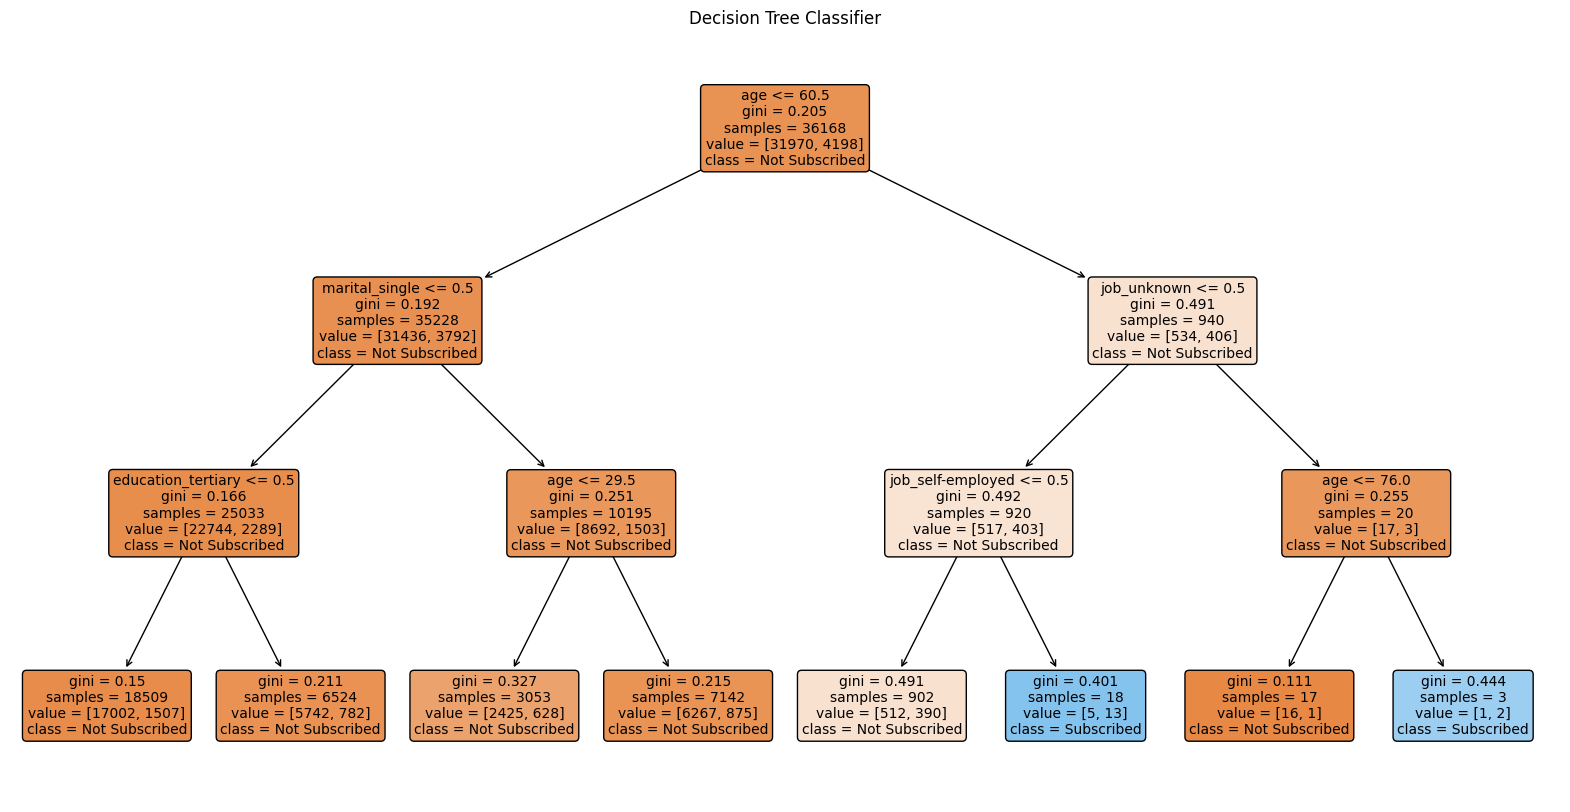

In [392]:
# Step 7: Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X_encoded.columns, class_names=["Not Subscribed", "Subscribed"], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Classifier")
plt.show()

<Figure size 1000x600 with 0 Axes>

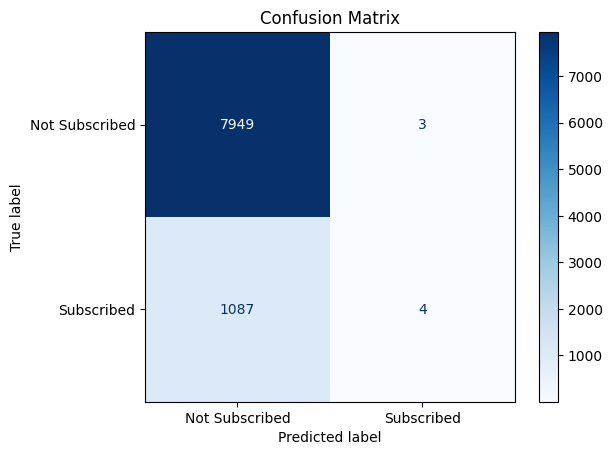

In [393]:
# Confusion Matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test_encoded, y_test_encoded, display_labels=["Not Subscribed", "Subscribed"], cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

Best parameters found:  {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}
Optimized Accuracy: 0.8795753621585757
Optimized Precision: 0.6666666666666666
Optimized Recall: 0.0036663611365719525
Optimized F1-score: 0.007292616226071104


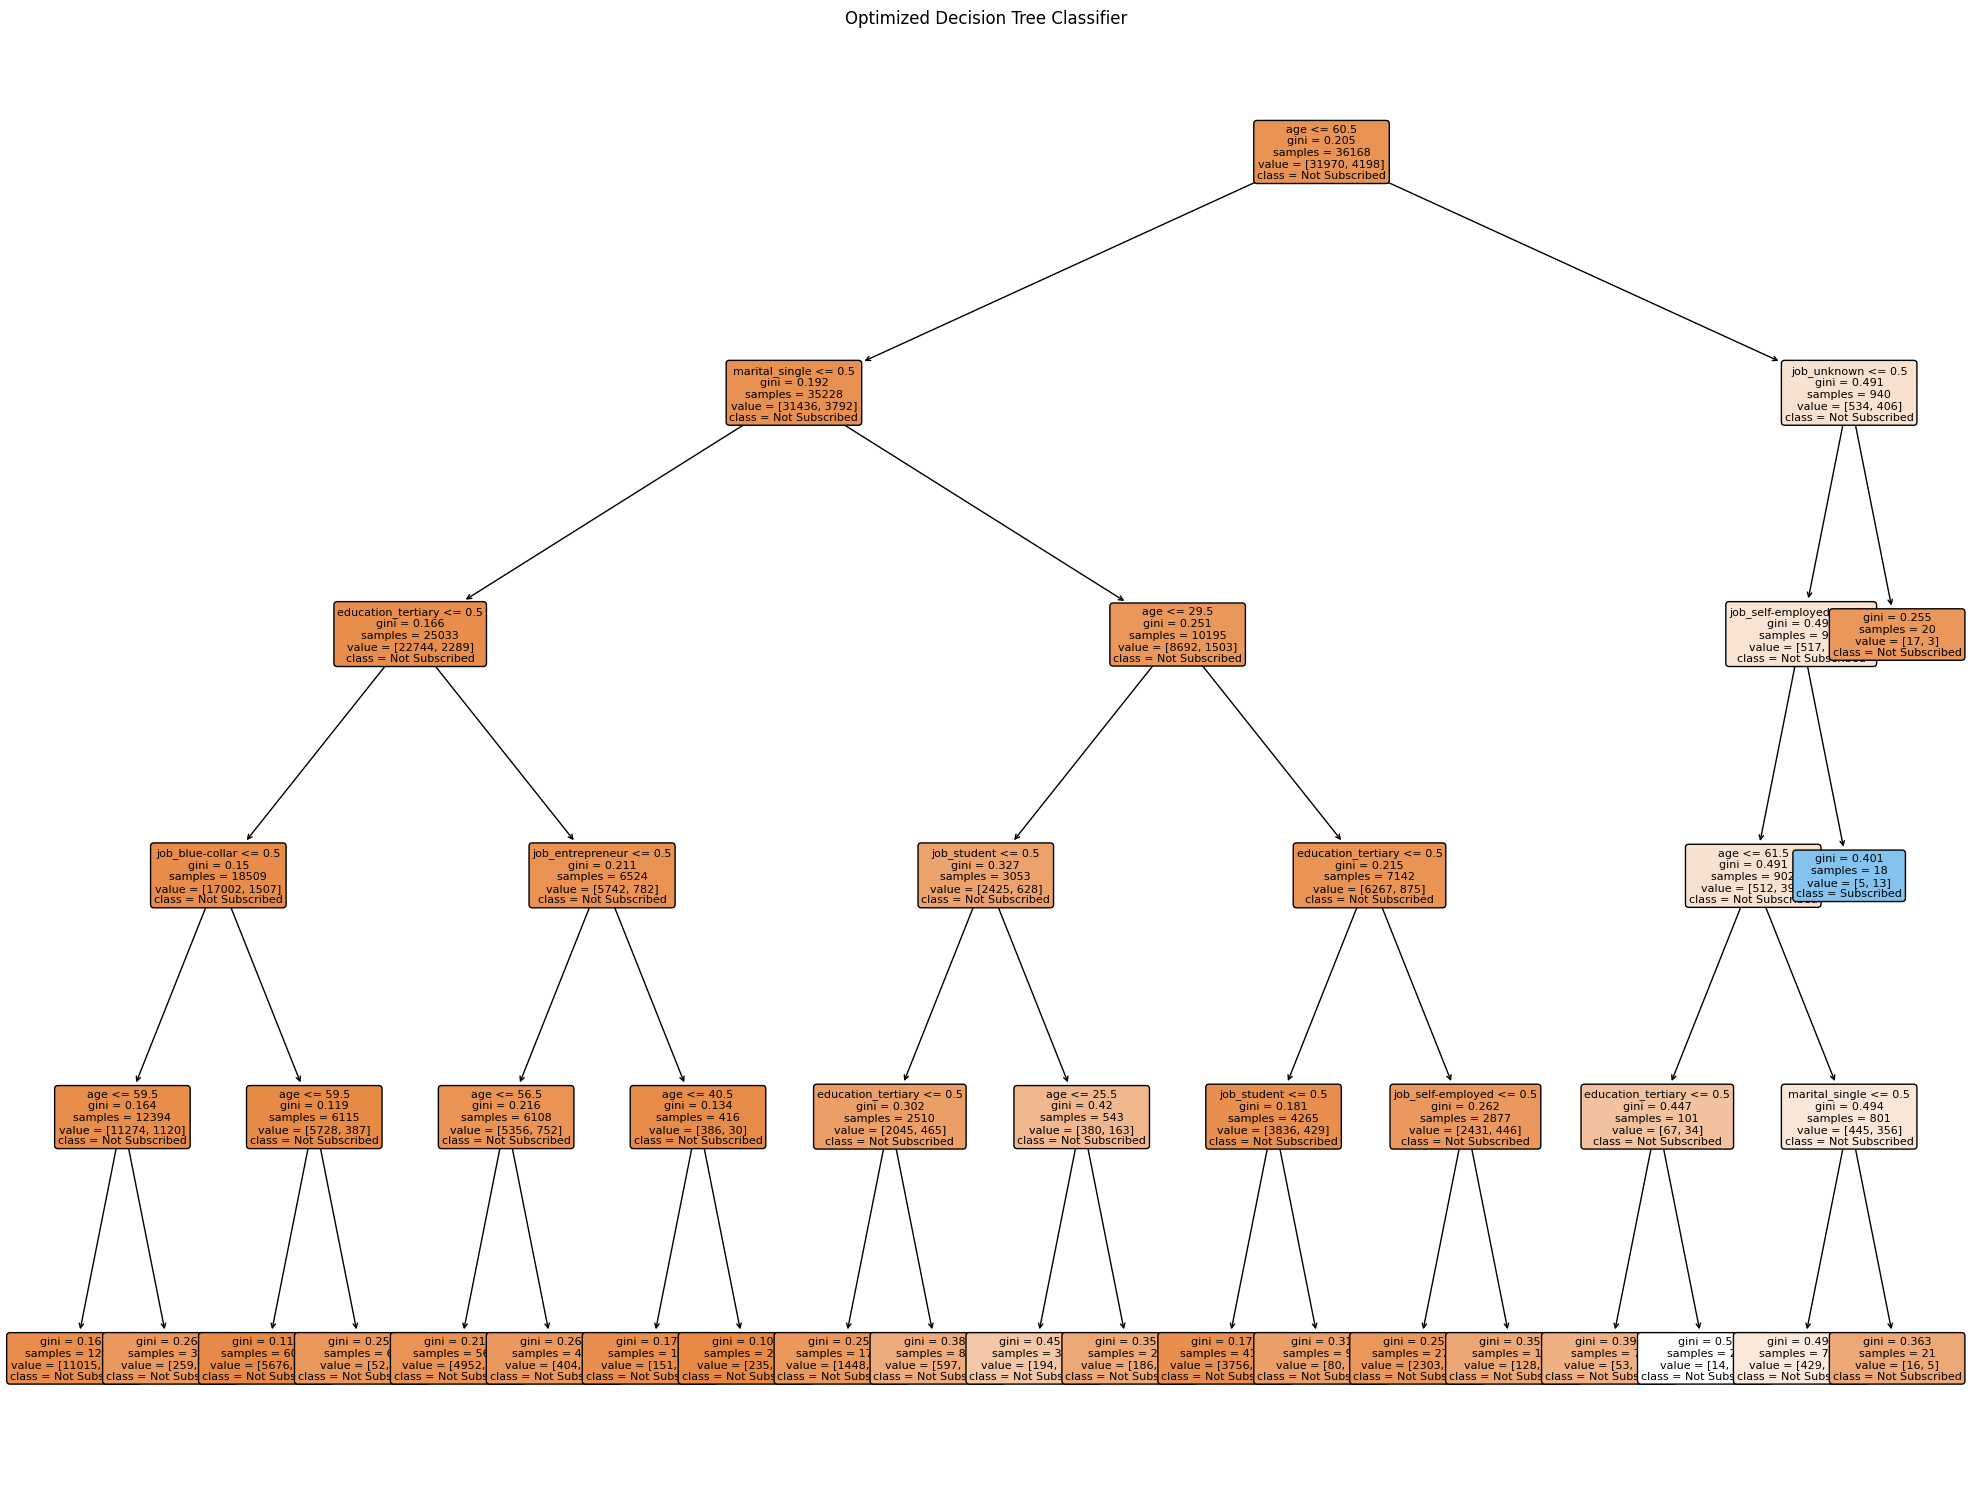

<Figure size 1000x600 with 0 Axes>

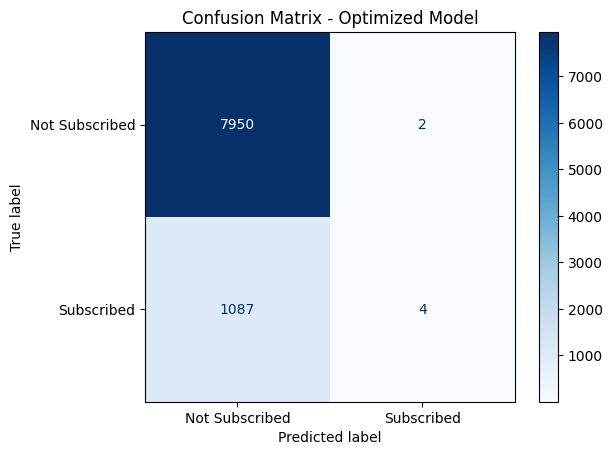

In [394]:
# Step 8: Tune Hyperparameters (Optional)
# Experiment with hyperparameters (e.g., max depth, min samples per leaf)
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]  # Replaced 'auto' with 'sqrt'
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_encoded, y_train_encoded)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
clf_best = DecisionTreeClassifier(**best_params)
clf_best.fit(X_train_encoded, y_train_encoded)

# Evaluate the optimized model
y_pred_best = clf_best.predict(X_test_encoded)
print("Optimized Accuracy:", accuracy_score(y_test_encoded, y_pred_best))
print("Optimized Precision:", precision_score(y_test_encoded, y_pred_best))
print("Optimized Recall:", recall_score(y_test_encoded, y_pred_best))
print("Optimized F1-score:", f1_score(y_test_encoded, y_pred_best))

# Visualize the optimized decision tree
plt.figure(figsize=(20, 15))
plot_tree(clf_best, feature_names=X_train_encoded.columns, class_names=["Not Subscribed", "Subscribed"], filled=True, rounded=True, fontsize=8)
plt.title("Optimized Decision Tree Classifier")
plt.tight_layout()
plt.show()

# Confusion Matrix for optimized model
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay.from_estimator(clf_best, X_test_encoded, y_test_encoded, display_labels=["Not Subscribed", "Subscribed"], cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - Optimized Model")
plt.show()

Customer 1:
Prediction (1 indicates Subscribed, 0 indicates not Subscribed): 0
Prediction probability (probability of each class): [0.91130967 0.08869033]

Customer 2:
Prediction (1 indicates Subscribed, 0 indicates not Subscribed): 0
Prediction probability (probability of each class): [0.8498155 0.1501845]

Customer 3:
Prediction (1 indicates Subscribed, 0 indicates not Subscribed): 0
Prediction probability (probability of each class): [0.93756194 0.06243806]



unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


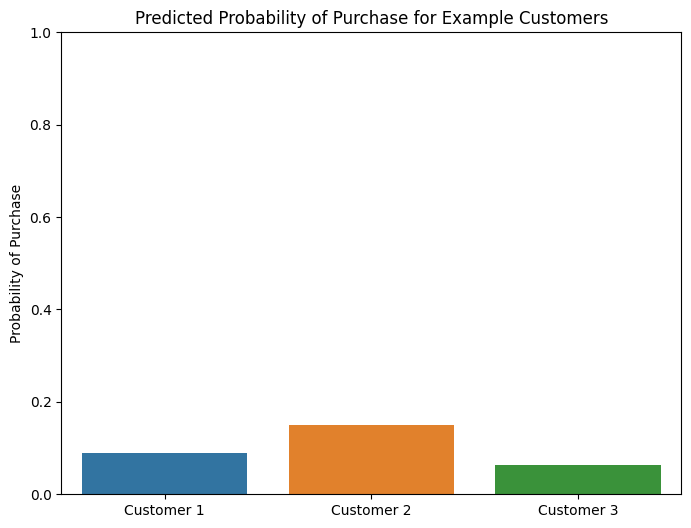

In [395]:
# Step 9: Make Predictions
# Use the trained model to predict whether a customer will make a purchase
example_customers = pd.DataFrame({
    'age': [30, 40, 50],
    'job_blue-collar': [0, 0, 1],
    'job_entrepreneur': [0, 1, 0],
    'job_housemaid': [0, 0, 0],
    'job_management': [0, 0, 0],
    'job_retired': [0, 0, 0],
    'job_self-employed': [0, 0, 0],
    'job_services': [0, 0, 0],
    'job_student': [0, 0, 0],
    'job_technician': [1, 0, 0],
    'job_unemployed': [0, 0, 0],
    'job_unknown': [0, 0, 0],
    'marital_married': [1, 0, 1],
    'marital_single': [0, 1, 0],
    'education_secondary': [1, 0, 1],
    'education_tertiary': [0, 1, 0],
    'education_unknown': [0, 0, 0]
})
predictions = clf_best.predict(example_customers)
predictions_proba = clf_best.predict_proba(example_customers)
for i, (pred, proba) in enumerate(zip(predictions, predictions_proba)):
    print(f"Customer {i+1}:")
    print("Prediction (1 indicates Subscribed, 0 indicates not Subscribed):", pred)
    print("Prediction probability (probability of each class):", proba)
    print()

# Visualization of the predictions
plt.figure(figsize=(8, 6))
sns.barplot(x=['Customer 1', 'Customer 2', 'Customer 3'], y=[proba[1] for proba in predictions_proba])
plt.title('Predicted Probability of Purchase for Example Customers')
plt.ylabel('Probability of Purchase')
plt.ylim(0, 1)
plt.show()

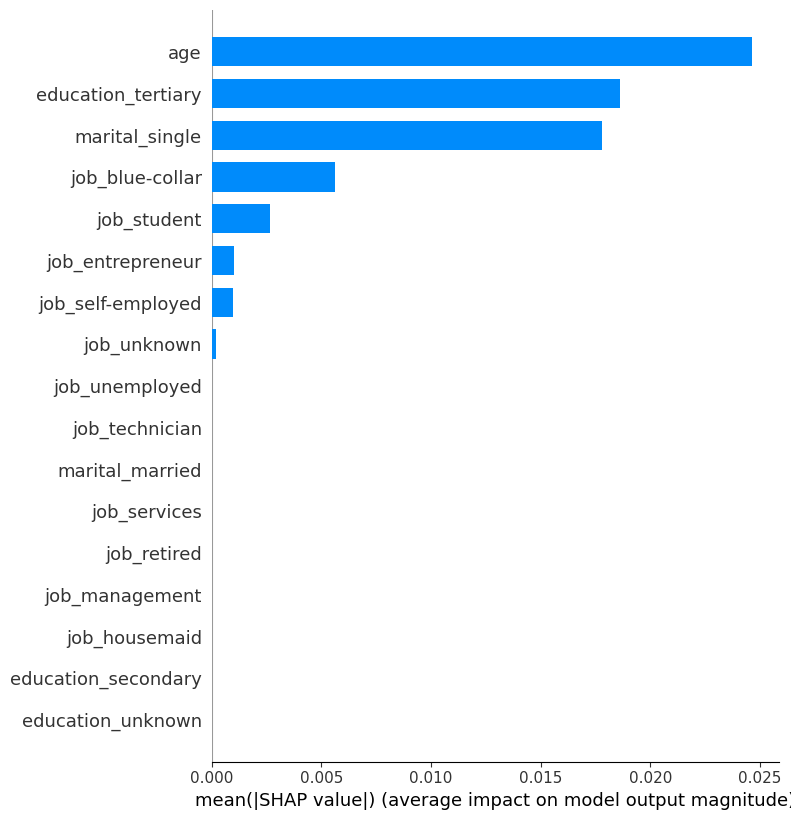

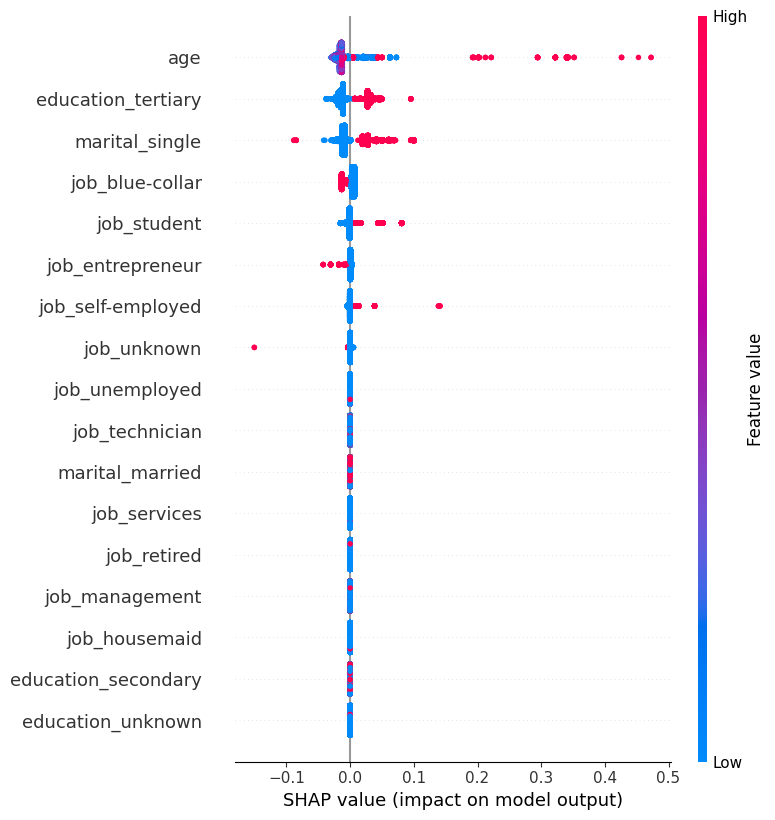

Feature Importances:
                Feature  Importance
0                   age    0.668357
13       marital_single    0.135474
15   education_tertiary    0.110404
8           job_student    0.038658
1       job_blue-collar    0.017217
6     job_self-employed    0.014768
11          job_unknown    0.009313
2      job_entrepreneur    0.005809
4        job_management    0.000000
5           job_retired    0.000000
7          job_services    0.000000
9        job_technician    0.000000
10       job_unemployed    0.000000
12      marital_married    0.000000
3         job_housemaid    0.000000
14  education_secondary    0.000000
16    education_unknown    0.000000


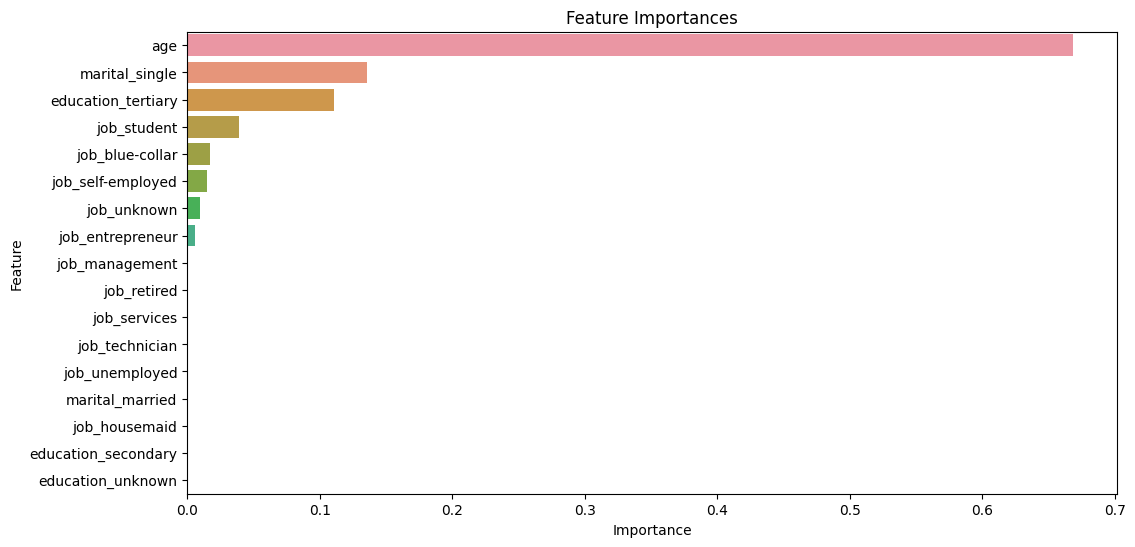

Decision Tree Rules:

|--- age <= 60.50
|   |--- marital_single <= 0.50
|   |   |--- education_tertiary <= 0.50
|   |   |   |--- job_blue-collar <= 0.50
|   |   |   |   |--- age <= 59.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  59.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- job_blue-collar >  0.50
|   |   |   |   |--- age <= 59.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  59.50
|   |   |   |   |   |--- class: 0
|   |   |--- education_tertiary >  0.50
|   |   |   |--- job_entrepreneur <= 0.50
|   |   |   |   |--- age <= 56.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  56.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- job_entrepreneur >  0.50
|   |   |   |   |--- age <= 40.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  40.50
|   |   |   |   |   |--- class: 0
|   |--- marital_single >  0.50
|   |   |--- age <= 29.50
|   |   |   |--- job_student <= 0.50
|   |   |   |   |--- education_tertiary <= 

In [396]:
# Step 10: Interpret the Results
# Analyze feature importance and decision rules from the decision tree
explainer = shap.TreeExplainer(clf_best)
shap_values = explainer.shap_values(X_test_encoded)
shap.summary_plot(shap_values[1], X_test_encoded, plot_type="bar", feature_names=X_encoded.columns)
shap.summary_plot(shap_values[1], X_test_encoded, feature_names=X_encoded.columns)
feature_importances = clf_best.feature_importances_
feature_names = X_encoded.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(importance_df)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()
tree_rules = export_text(clf_best, feature_names=list(X_encoded.columns))
print("Decision Tree Rules:\n")
print(tree_rules)

In [402]:
# Export the decision tree to a file
dot_data = export_graphviz(clf_best, out_file=None, 
                           feature_names=X_encoded.columns, 
                           class_names=["Not Subcribed", "Subcribed"],
                           filled=True, rounded=True, special_characters=True)

# Save the decision tree to a PNG file with specified DPI
graph = graphviz.Source(dot_data, format="png")
graph.render("optimized_decision_tree", view=False, cleanup=True)

'optimized_decision_tree.png'